In [1]:
import meep as mp
import math
import numpy as np
import matplotlib.pyplot as plt

resolution = 40        # pixels/μm

dpml = 1.0             # PML thickness
dsub = 3.0             # substrate thickness
dpad = 3.0             # padding between grating and PML
gp = 10.0              # grating period
gh = 0.5               # grating height
gdc = 0.5              # grating duty cycle

sx = dpml+dsub+gh+dpad+dpml
cell_size = mp.Vector3(sx)

pml_layers = [mp.PML(thickness=dpml,direction=mp.X)]

wvl_min = 0.4           # min wavelength
wvl_max = 0.6           # max wavelength
fmin = 1/wvl_max        # min frequency
fmax = 1/wvl_min        # max frequency
fcen = 0.5*(fmin+fmax)  # center frequency
df = fmax-fmin          # frequency width

src_pt = mp.Vector3(-0.5*sx+dpml+0.5*dsub)
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Ez, center=src_pt)]

k_point = mp.Vector3()

glass = mp.Medium(index=1.5)

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    k_point=k_point,
                    default_material=glass,
                    sources=sources)

nfreq = 21
n2f_pt = mp.Vector3(0.5*sx-dpml-0.5*dpad)
n2f_obj = sim.add_near2far(fcen, df, nfreq, mp.Near2FarRegion(center=n2f_pt))

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, n2f_pt, 1e-9))

ff_distance = 1e8    # far-field distance from near fields
ff_angle = 20        # far-field cone angle
ff_npts = 500       # number of far-field points

ff_length = ff_distance*math.tan(math.radians(ff_angle))
ff_res = ff_npts/ff_length

ff_source = np.absolute(sim.get_farfields(n2f_obj, ff_res, center=mp.Vector3(ff_distance,0.5*ff_length), size=mp.Vector3(y=ff_length))['Ez'][0])**2

sim.reset_meep()

sy = gp
cell_size = mp.Vector3(sx,sy)
symmetries = [mp.Mirror(mp.Y)]

sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Ez, center=src_pt, size=mp.Vector3(y=sy))]

geometry = [mp.Block(material=glass, size=mp.Vector3(dpml+dsub,mp.inf,mp.inf), center=mp.Vector3(-0.5*sx+0.5*(dpml+dsub))),
            mp.Block(material=glass, size=mp.Vector3(gh,gdc*gp,mp.inf), center=mp.Vector3(-0.5*sx+dpml+dsub+0.5*gh))]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    k_point=k_point,
                    sources=sources,
                    symmetries=symmetries)

nperiods = 10
n2f_obj = sim.add_near2far(fcen, df, nfreq, mp.Near2FarRegion(center=n2f_pt, size=mp.Vector3(y=sy)), nperiods=nperiods)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, n2f_pt, 1e-9))

ff_grating = np.absolute(sim.get_farfields(n2f_obj, ff_res, center=mp.Vector3(ff_distance,0.5*ff_length), size=mp.Vector3(y=ff_length))['Ez'][0])**2

freqs = mp.get_near2far_freqs(n2f_obj)
tran = ff_grating/ff_source
wvl = np.divide(1,freqs)
ff_lengths = np.linspace(0,ff_length,ff_npts)
angles = [math.degrees(math.atan(f)) for f in ff_lengths/ff_distance]

-----------
Initializing structure...
Working in 2D dimensions.
Computational cell is 8.5 x 0.025 x 0 with resolution 40
time for set_epsilon = 0.00195909 s
-----------
field decay(t = 50.0125): 0.11652658128306856 / 0.11652658128306856 = 1.0
field decay(t = 100.025): 1.9732739090938007e-15 / 0.11652658128306856 = 1.6934109688675124e-14
run 0 finished at t = 100.025 (8002 timesteps)

Field time usage:
        connecting chunks: 0.00358725 s
            time stepping: 0.287517 s
            communicating: 0.14256 s
     Fourier transforming: 0.0542099 s
          everything else: 0.225066 s

-----------
Initializing structure...
Halving computational cell along direction y
Working in 2D dimensions.
Computational cell is 8.5 x 10 x 0 with resolution 40
     block, center = (-2.25,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,0)
          size (0.5,5,1e+20)
          

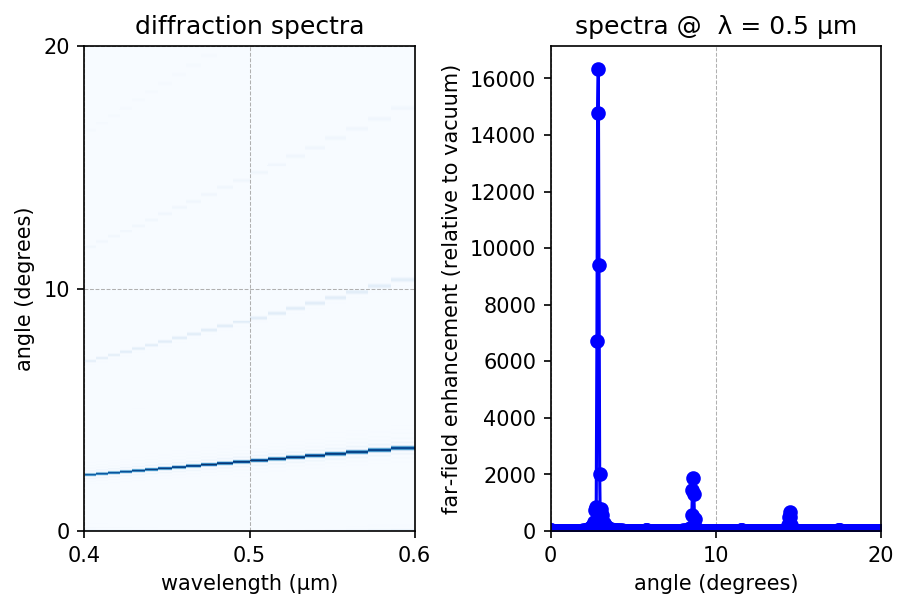

In [2]:
plt.figure(dpi=150)

plt.subplot(1,2,1)
plt.pcolormesh(wvl,angles,tran,cmap='Blues',shading='flat')
plt.axis([wvl_min, wvl_max, 0, ff_angle])
plt.xlabel("wavelength (μm)")
plt.ylabel("angle (degrees)")
plt.grid(linewidth=0.5,linestyle='--')
plt.xticks([t for t in np.arange(wvl_min,wvl_max+0.1,0.1)])
plt.yticks([t for t in range(0,ff_angle+1,10)])
plt.title("diffraction spectra")

wvl_slice = 0.5
idx_slice = np.where(np.asarray(freqs) == 1/wvl_slice)[0][0]
plt.subplot(1,2,2)
plt.plot(angles,tran[:,idx_slice],'bo-')
plt.xlim(0,ff_angle)
plt.ylim(0)
plt.xticks([t for t in range(0,ff_angle+1,10)])
plt.xlabel("angle (degrees)")
plt.ylabel("far-field enhancement (relative to vacuum)")
plt.grid(axis='x',linewidth=0.5,linestyle='--')
plt.title("spectra @  λ = {:.1} μm".format(wvl_slice))

plt.tight_layout(pad=0.5)
plt.show()

In [3]:
kx = lambda m,freq: math.sqrt(freq**2 - (m/gp)**2)
theta_out = lambda m,freq: math.acos(kx(m,freq)/freq)

tol = 0.02
modes = [1,3,5]
idx_modes = np.zeros(len(modes))
for j in range(len(modes)):
    idx_modes[j] = np.nonzero(np.logical_and(np.asarray(angles) > math.degrees(theta_out(modes[j],1/wvl_slice))-tol,
                                             np.asarray(angles) < math.degrees(theta_out(modes[j],1/wvl_slice))+tol))[0][0]

print("peak-ratios:, {}, {}".format(tran[int(idx_modes[0]),idx_slice]/tran[int(idx_modes[1]),idx_slice],
                                    tran[int(idx_modes[1]),idx_slice]/tran[int(idx_modes[2]),idx_slice]))

peak-ratios:, 8.750879648602615, 2.825409394217622
